In [2]:
import cv2
import numpy as np
import os
from abc import ABC, abstractmethod
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
import pandas as pd
import imageio.v3 as iio
from typing import Tuple, List, Dict, Optional, Union
from skimage import color

In [3]:
# naming for positions jpg: YY/MM/DD_Positions_CamID.jpg
# naming for template jpg: CamID_ObjectToFind_levelA_template0.jpg
# grayscaling with imageio/skimate/opencv!

In [21]:
class Match(ABC):
    """
    Class, that represents a matched template.

    Attributes:
        self.num_iterations(int): number of following sublevels for template matching
        self.offset(Tuple): offset of the cropped image, in which the next matching is performed
        self.accuracy(float): accuracy of the matching, multiplied with the new accuracy of every new match
        self.image(numpy.ndarray): cropped image, in which the template matching is performed
    """
    def __init__(self, num_iterations: int, image: np.ndarray, offset: Tuple[int, int]=(0, 0), accuracy: float=1)->None:
        """
        Constructor for class Match.
        
        Parameters:
            num_iterations(int): number of following sublevels for template matching
            offset(Tuple): offset of the cropped image, in which the next matching is performed
            accuracy(float): accuracy of the matching, multiplied with the new accuracy of every new match
            image(numpy.ndarray): cropped image, in which the template matching is performed
        """
        self.num_iterations = num_iterations
        self.offset = offset
        self.accuracy = accuracy
        self.image = image
        
    
    def _get_template_images(self, level:str, filepaths: List)->List:
        """
        Function, that opens templates from the template directory and returns them as List of np.ndarrays.
        
        Parameter:
            level(str): level of template matching in alphabetic order as specified in filename of the template
            filepaths(List): List of filepaths to all templates of one marker
        """
        return [iio.imread(template) for template in filepaths if 'level'+level in template]
        
        
    def run(self, filepaths: str, level: str='A')->List:
        """
        Function, that runs the template matching, if num_iterations is >0.
        
        Template matching returns a list of matches inside the match of the next higher level.
        If num_iterations is 0, the lowest match overwrites the tree of higher order templates, 
        as it is returned.
        
        Parameter:
            level(str): level of template matching in alphabetic order as specified in filename of the template
            filepaths(List): List of filepaths to all templates of one marker
        """
        if self.num_iterations>0:
            self.matches = self._iterate_template_matching(filepaths = filepaths, level=level)
            next_level = 'ABCD'['ABCD'.index(level)+1]
            return [match.run(level=next_level, filepaths=filepaths) for match in self.matches]
        else:
            return self
                
    def _match_template(self, template: np.ndarray) -> np.ndarray:
        """ Function, that calls the template matching function of opencv. """
        method = cv2.TM_CCORR_NORMED #cv2.TM_SQDIFF_NORMED, cv2.TM_CCOEFF_NORMED
        result = cv2.matchTemplate(image = self.image, templ = template, method = method)
        return result

    def _iterate_template_matching(self, filepaths: str, level: str)->List:
        """
        Function, that creates a heatmap of the found results by calculating the mean over multiple results.
        
        The result arrays of _match_template are padded to the same size before calculating the mean.
        One (for the last iteration) or five peaks in the heatmap are returned and new Match objects are created for them.
        
        Parameter:
            level(str): level of template matching in alphabetic order as specified in filename of the template
            filepaths(List): List of filepaths to all templates of one marker
            
        Results: 
            matches(List): List of new Match objects
        """
        if self.num_iterations == 1:
            max_peaks = 1
        else:
            max_peaks = 5
        templates = self._get_template_images(filepaths=filepaths, level=level)
        results_for_heatmap = [self._match_template(template = template) for template in templates]
        template_shape = (max([template.shape[0] for template in templates]), max([template.shape[1] for template in templates]))
        
        if len(results_for_heatmap)!=0:
            pad_length, pad_width = max([result.shape[0] for result in results_for_heatmap]), max([result.shape[1] for result in results_for_heatmap])
            padded_results = [np.pad(result, ((0, pad_length - result.shape[0]), (0, pad_width - result.shape[1]))) for result in results_for_heatmap]
            mean_intensity_values = np.mean(np.array(padded_results), axis=0)
            
            locations = peak_local_max(mean_intensity_values, num_peaks=max_peaks)
            
            matches = []
            if len(locations)!=0:
                for y, x in locations:
                    trimmed_image, new_offset=self._trim_image_get_offset(xy=(x, y), template_shape = template_shape)
                    new_accuracy = mean_intensity_values[y, x]*self.accuracy
                    matches.append(Match(num_iterations=self.num_iterations-1, image=trimmed_image, offset=new_offset, accuracy=new_accuracy))  
            return matches

    def _trim_image_get_offset(self, xy: Tuple[int, int], template_shape: Tuple[int, int])->Tuple[np.ndarray, Tuple[int, int]]:
        """
        Function, that trims the image and calculates the offset, based on the found matching location.
        
        If the template of the next level doesn't match the size of the trimmed image, the original is returned.
        
        Parameters:
            xy(Tuple): x and y coordinate of a found match.
            template_shape(Tuple): shape of the biggest template of the current level.
            
        Returns:
            trimmed_image: image trimmed to the found locations depending on the maximum template size.
            offset: offset of the returned trimmed_image.
        """
        if (template_shape[0]+xy[1])>self.image.shape[0] or (template_shape[1]+xy[0])>self.image.shape[1]:
            return self.image, self.offset
        else:
            trimmed_image = self.image[xy[1]:xy[1]+template_shape[0]+1, xy[0]:xy[0]+template_shape[1]+1]
            if self.num_iterations==1:
                offset = self.offset[0]+xy[0]+template_shape[1]//2, self.offset[1]+xy[1]+template_shape[0]//2
                #template shape for calculating the mean pixel coordinate is not exact!
            else:
                offset = self.offset[0]+xy[0], self.offset[1]+xy[1]
        return trimmed_image, offset
    
class Marker(ABC):
    """
    Class, that represents a single marker, that should be found in the positions image.
    
    Attributes:
        self.marker_id(str): unique ID of the marker
        self.filepaths(List): filepaths in the template directory with the marker_id
        self.levels(numpy.array): array of unique levels for the marker
    """
    def __init__(self, marker_id: str, filepaths: List)->None:
        """
        Constructor for class markers.
        
        Parameters:
            self.marker_id(str): unique ID of the marker
            self.filepaths(List): filepaths in the template directory with the marker_id
        """
        self.marker_id = marker_id
        self.levels = np.unique(np.array([elem[elem.index('level')+5:elem.index('level')+6] for elem in filepaths]))
        self.filepaths = filepaths
    
    def run(self, original_image: np.ndarray)->Tuple[Tuple[int, int], float, str]:
        """
        This function takes an original image and creates a Match object for the marker.
        
        After all iterations are done, the result with the highest accuracy is returned.
        
        Parameters:
            original_image(np.ndarray): the positions image
            
        Returns: 
            coordinates(Tuple): coordinates of the best match or (0, 0) if no match was found
            likelihood(float): accuracy for the detected match multiplied with the accuracy of all previous matches. set to 0 if no match was found.
            marker_id(str): the unique label of the marker
        """
        image = original_image.copy()
        #image = color.rgb2gray(image)
        match = Match(num_iterations=len(self.levels), image=image)
        final_matches = [item[0] for sublist in match.run(filepaths=self.filepaths) for item in sublist]
        
        if len(final_matches)!=0:
            index_best_match = [match.accuracy for match in final_matches].index(max([match.accuracy for match in final_matches]))
            best_match = final_matches[index_best_match]
            best_location_yx = best_match.offset
            likelihood = best_match.accuracy
            best_location_xy = best_location_yx[1], best_location_yx[0]
            coordinates = best_location_yx
            return coordinates, likelihood, self.marker_id
        else:
            print(f'No match found for {self.marker_id}! \n Set likelihood to 0 and position to (0, 0).')
            return (0, 0), 0, self.marker_id

class TemplateMatching(ABC):
    """
    Class, that represents the Template Matching for one single camera.
    
    Attributes:
        self.directory_positions_jpg(str): the directory, where the Positions image for the camera is stored.
        self.visualize_matching(Boolean): defines, whether the found markers are plotted.
        self.cam_id(str): unique id for the camera.
    """
    @property
    def template_directory(self) ->str:
        """ Property, that defines the template path. Has to be initialized for every user or adapted, if the directory is changed. """
        return r"/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/templates_obj/"
    
    @property
    def template_naming(self) ->str:
        """ Specific naming for the templates. Therefore, the correct filename of templates is crucial: CamID_ObjectToFind_levelA_template0.jpg """
        return 'template'
    
    @property
    def positions_naming(self) -> str:
        """ Specific naming for the positions. Besides the flag '_Positions', also the CamID is crucial: YY/MM/DD_Positions_CamID.jpg """
        return '_Positions'
    
    
    def __init__(self, directory_positions_jpg: str, cam_id: str, visualize_matching: bool = False)->None:
        """
        Constructor for the class TemplateMatching.
        
        Parameters:
            directory_positions_jpg(str): the directory, where the Positions image for the camera is stored.
            visualize_matching(Boolean): defines, whether the found markers are plotted.
            cam_id(str): unique id for the camera.
        """
        self.directory_positions_jpg = directory_positions_jpg
        self.visualize_matching = visualize_matching
        self.cam_id = cam_id
            
    def export_as_DLC_h5(self) -> None:
        """
        Function, that exports the found labels to a faked deeplabcut .csv file.
        """
        df = self._construct_dlc_output_style_df_from_manual_marker_coords()
        if self.visualize_matching:
            print(df)
        output_filepath = f'{self.cam_id}_templatematched_test_position_marker_fake.h5'
        df.to_hdf(output_filepath, "df")
        
        
    def run(self)->None:
        """
        Function, that creates Markers objects and runs template matching.
        
        The positions file for the camera with the specified camera ID is located,
        Marker objects for every template with unique marker_id are created and the 
        original Positions image is loaded. After performing template matching on the
        markers, the found results are added to a dictionary and visualized if wanted.
        """
        print(f'Now analyzing {self.cam_id}!')
        self.path_positions = self._get_positions_path()
        self.markers = self._get_markers()
        self.original_image = iio.imread(self.path_positions, index=0)
        for marker in self.markers:
            coordinates, likelihood, marker_id = marker.run(original_image=self.original_image)
            self._add_templatematched_test_position_marker(marker_id = marker_id, x_or_column_idx = coordinates[0], y_or_row_idx = coordinates[1], likelihood = likelihood, overwrite = False)
        if self.visualize_matching:
            self._visualize_predictions()
                
    def _add_templatematched_test_position_marker(self, marker_id: str, x_or_column_idx: int, y_or_row_idx: int, likelihood: float, overwrite: bool=False) -> None:
        """
        Function, that adds a marker to the dictionary, where the results are stored.
        
        If the marker was not added already, it is stored in the Dict self.manual_test_position_marker_coords_pred.
        
        Parameters:
            marker_id(str): unique label for the marker
            x_or_column_idx(int): x position of a found match
            y_or_row_idx(int): y position of a found match
            likelihood(float): likelihood of the matched template
            overwrite(bool): defines, whether a marker should be overwritten, if the marker has already a position.
        """
        if hasattr(self, 'manual_test_position_marker_coords_pred') == False:
            self.manual_test_position_marker_coords_pred = {}
        if (marker_id in self.manual_test_position_marker_coords_pred.keys()) & (overwrite == False):
            raise ValueError('There are already coordinates for the marker you '
                             f'tried to add: "{marker_id}: {self.manual_test_position_marker_coords_pred[marker_id]}'
                             '". If you would like to overwrite these coordinates, please pass '
                             '"overwrite = True" as additional argument to this method!')
        self.manual_test_position_marker_coords_pred[marker_id] = {'x': [x_or_column_idx], 'y': [y_or_row_idx], 'likelihood': [likelihood]}
    
    
    def _construct_dlc_output_style_df_from_manual_marker_coords(self) -> pd.DataFrame:
        """
        Function, that constructs a dlc-like pandas Dataframe.
        
        Returns:
            df(pandas.DataFrame): DataFrame containing the position of all found markers.
        """
        multi_index = self._get_multi_index()
        df = pd.DataFrame(data = {}, columns = multi_index)
        for scorer, marker_id, key in df.columns:
            df[(scorer, marker_id, key)] = self.manual_test_position_marker_coords_pred[marker_id][key]
        return df
    
    
    def _get_multi_index(self) -> pd.MultiIndex:
        """ Function, that creates and returns a DLC-like pandas.MultiIndex. """
        multi_index_column_names = [[], [], []]
        for marker_id in self.manual_test_position_marker_coords_pred.keys():
            for column_name in ("x", "y", "likelihood"):
                multi_index_column_names[0].append("templatematched_marker_positions")
                multi_index_column_names[1].append(marker_id)
                multi_index_column_names[2].append(column_name)
        return pd.MultiIndex.from_arrays(multi_index_column_names, names=('scorer', 'bodyparts', 'coords'))
    
    
    def _get_positions_path(self) -> str:  
        """ Function, that finds and returns the _Positions file, that matches the cam_id. """
        for elem in os.listdir(self.directory_positions_jpg):
            if self.positions_naming in elem and self.cam_id in elem:
                return self.directory_positions_jpg + elem
        if "filepath" not in locals(): 
            raise FileNotFoundError(f'Found no suiting _Positions file for {self.cam_id}!') 
    
    
    def _get_markers(self) -> List:
        """ Function, that creates and returns a List with Marker objects for each template with unique marker_id. """
        all_filepaths = [elem for elem in os.listdir(self.template_directory) if self.template_naming in elem and self.cam_id in elem]
        if len(all_filepaths) == 0:
            raise FileNotFoundError(f'Found no suiting templates for {self.cam_id}')
            
        markers = []
        for filepath in all_filepaths:
            split_name = filepath.split("_")
            marker_id, level = split_name[1], split_name[2]
            if marker_id not in [marker.marker_id for marker in markers]:
                filepaths = [self.template_directory + elem for elem in all_filepaths if marker_id in elem]
                markers.append(Marker(marker_id, filepaths))
        return markers
            
    
    def _visualize_predictions(self)-> None:
        """ Function, that plots the original_image with the found position markers. """
        fig = plt.figure(figsize = (20, 10))

        image = iio.imread(self.path_positions, index=0)
        plt.imshow(image)
        for marker in self.markers:
            plt.scatter(self.manual_test_position_marker_coords_pred[marker.marker_id]['x'], self.manual_test_position_marker_coords_pred[marker.marker_id]['y'])
            plt.text(self.manual_test_position_marker_coords_pred[marker.marker_id]['x'][0], self.manual_test_position_marker_coords_pred[marker.marker_id]['y'][0], marker.marker_id)
        plt.show()

Now analyzing Side1!
[] 0
No match found for MazeCornerOpenLeft! 
 Set likelihood to 0 and position to (0, 0).
[<__main__.Match object at 0x7fab421df250>, <__main__.Match object at 0x7fab421df5b0>, <__main__.Match object at 0x7fab421dfd60>, <__main__.Match object at 0x7fab421dfa90>, <__main__.Match object at 0x7fab421df310>, <__main__.Match object at 0x7fab8211d7f0>, <__main__.Match object at 0x7fab8211dbe0>, <__main__.Match object at 0x7fab8211dfa0>, <__main__.Match object at 0x7fab8211d730>, <__main__.Match object at 0x7fab8211dd30>, <__main__.Match object at 0x7fab8211c6d0>, <__main__.Match object at 0x7fab8211cac0>, <__main__.Match object at 0x7fab8211ce50>, <__main__.Match object at 0x7fab8211cbb0>, <__main__.Match object at 0x7fab82121fa0>, <__main__.Match object at 0x7fab82121f40>, <__main__.Match object at 0x7fab82121f10>, <__main__.Match object at 0x7fab821043d0>, <__main__.Match object at 0x7fab821045b0>, <__main__.Match object at 0x7fab821049a0>, <__main__.Match object at 0x

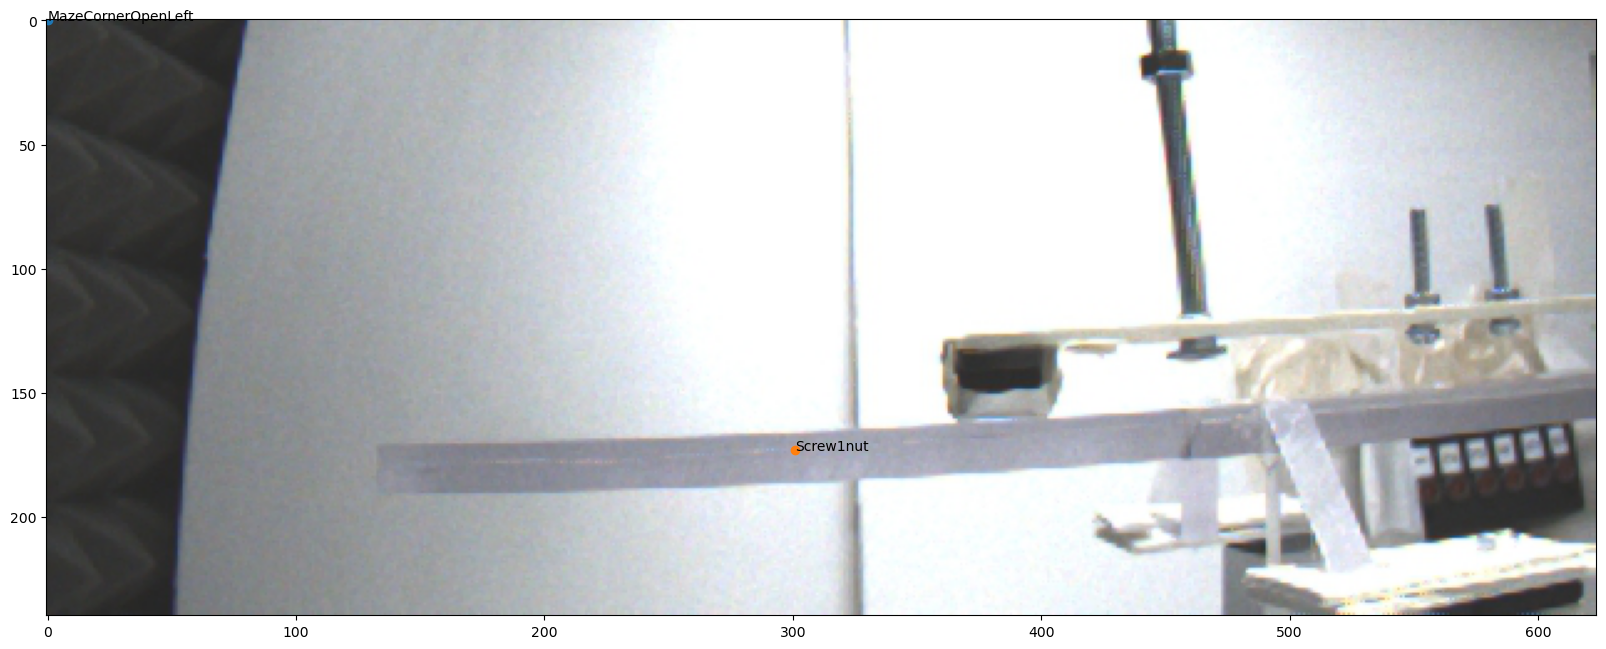

scorer    templatematched_marker_positions                               \
bodyparts               MazeCornerOpenLeft               Screw1nut        
coords                                   x  y likelihood         x    y   
0                                        0  0          0       301  173   

scorer                
bodyparts             
coords    likelihood  
0           0.767681  


In [22]:
Side1_220826 = TemplateMatching(directory_positions_jpg = '/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/positions/220826/', cam_id = "Side1", visualize_matching= True)
Side1_220826.run()
Side1_220826.export_as_DLC_h5()

Now analyzing Bottom!
[] 0
No match found for LED5! 
 Set likelihood to 0 and position to (0, 0).


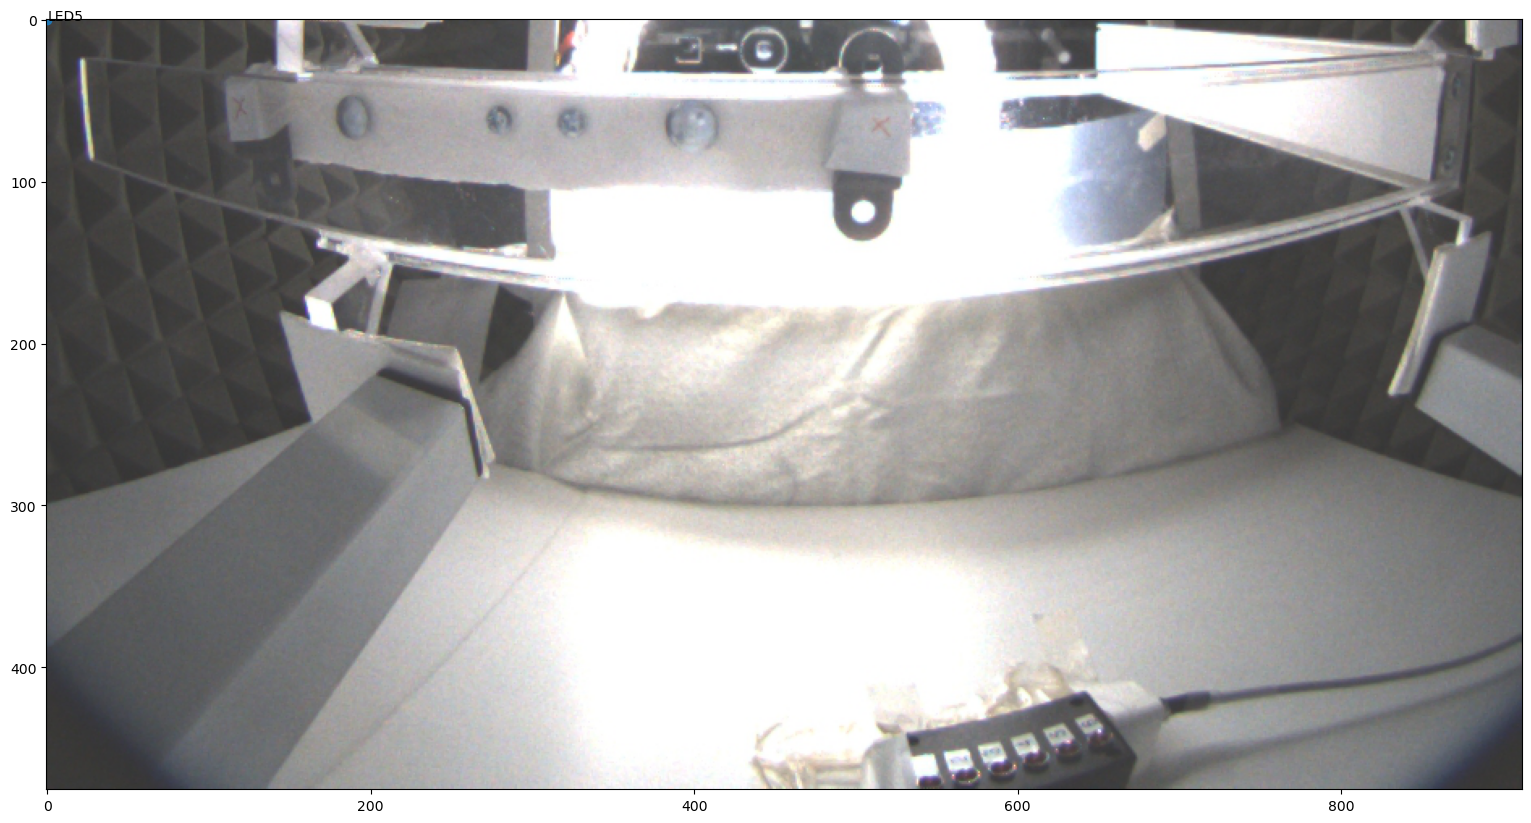

scorer    templatematched_marker_positions              
bodyparts                             LED5              
coords                                   x  y likelihood
0                                        0  0          0


In [23]:
Bottom_220826 = TemplateMatching(directory_positions_jpg = '/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/positions/220826/', cam_id = "Bottom", visualize_matching= True)
Bottom_220826.run()
Bottom_220826.export_as_DLC_h5()



In [113]:
Top_220826 = TemplateMatching(directory_positions_jpg = '/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/positions/220826/', cam_id = "Top", visualize_matching= True)
Top_220826.run()
Side2_220826 = TemplateMatching(directory_positions_jpg = '/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/positions/220826/', cam_id = "Side2", visualize_matching= True)
Side2_220826.run()
Ground1_220826 = TemplateMatching(directory_positions_jpg = '/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/positions/220826/', cam_id = "Ground1", visualize_matching= True)
Ground1_220826.run()
Ground2_220826 = TemplateMatching(directory_positions_jpg = '/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/positions/220826/', cam_id = "Ground2", visualize_matching= True)
Ground2_220826.run()

Now analyzing Top!


FileNotFoundError: Found no suiting templates for Top